# Practical Data Science
## Assignment 1

### Environment Initialization

Enable ploting inline within notebook

In [ ]:
%matplotlib inline

Import necessary libraries

In [401]:
import pandas
import numpy
import seaborn
import re
import difflib

### Import and clean data

#### Campaign donations data set

We import the campaign donations data set. The data can be found [here](ftp://ftp.fec.gov/FEC/Presidential_Map/2012/P00000001/P00000001-ALL.zip). The dictionary of this data set is [here](ftp://ftp.fec.gov/FEC/Presidential_Map/2012/DATA_DICTIONARIES/CONTRIBUTOR_FORMAT.txt). From the dictionary we can get the datatypes.

In [37]:
donations_data_types = {'cmte_id':numpy.str, 'cand_id':numpy.str, 'cand_nm':numpy.str, 
                        'contbr_nm':numpy.str, 'contbr_city':numpy.str, 'contbr_st':numpy.str, 
                        'contbr_zip':numpy.str, 'contbr_employer':numpy.str, 'contbr_occupation':numpy.str,
                        'contb_receipt_amt':numpy.float, 'contb_receipt_dt':numpy.str, 'receipt_desc':numpy.str, 
                        'memo_cd':numpy.str, 'memo_text':numpy.str, 'form_tp':numpy.str,
                        'file_num':numpy.int, 'tran_id':numpy.str, 'election_tp':numpy.str}
donations_date_parser = lambda x: pandas.to_datetime(x, infer_datetime_format = True)
donations = pandas.read_csv("donations/P00000001-ALL.csv", dtype = donations_data_types, index_col = False,
                            date_parser = donations_date_parser, parse_dates = ['contb_receipt_dt'])

In [177]:
donations = donations_copy.copy(deep=True)

The `election_tp` column indicates the election for which the contribution was made. The posible values are:

In [178]:
donations.election_tp.unique()

array(['P2012', 'G2012', nan, 'P2008', 'G2008', 'O2012', 'P2102', 'P2014',
       'P', 'P2011'], dtype=object)

We observer that there are entries refering to the campaigns of 2008, as well as entries that seem like typos. We will investigate each one.

The `P2008` and `G2008` values. There are 767 entries that refer to the 2008 primaries and general elections.

In [179]:
len(donations[donations.election_tp.isin(['P2008', 'G2008'])])

767

In [180]:
donations.contb_receipt_dt[donations.election_tp.isin(['P2008', 'G2008'])].unique()

array(['2012-12-31T02:00:00.000000000+0200',
       '2011-06-30T03:00:00.000000000+0300',
       '2011-06-29T03:00:00.000000000+0300',
       '2011-06-27T03:00:00.000000000+0300',
       '2011-09-02T03:00:00.000000000+0300',
       '2012-08-23T03:00:00.000000000+0300',
       '2011-06-28T03:00:00.000000000+0300',
       '2012-05-22T03:00:00.000000000+0300',
       '2012-08-11T03:00:00.000000000+0300',
       '2012-01-28T02:00:00.000000000+0200',
       '2012-03-23T02:00:00.000000000+0200',
       '2012-05-29T03:00:00.000000000+0300',
       '2012-07-09T03:00:00.000000000+0300',
       '2012-06-13T03:00:00.000000000+0300',
       '2011-08-22T03:00:00.000000000+0300',
       '2012-09-21T03:00:00.000000000+0300',
       '2012-02-10T02:00:00.000000000+0200',
       '2011-06-24T03:00:00.000000000+0300',
       '2011-06-17T03:00:00.000000000+0300',
       '2012-06-22T03:00:00.000000000+0300',
       '2012-10-01T03:00:00.000000000+0300',
       '2011-07-28T03:00:00.000000000+0300',
       '20

We observe that there are some very old entries dated in 2008 and 2007. Let's have a look.

In [181]:
donations[(donations.election_tp.isin(['P2008', 'G2008'])) & (donations.contb_receipt_dt <= '2009')]

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num,tran_id,election_tp
5753551,C00495820,P80000748,"Paul, Ron","SIGMUNDSON, DALE MR.",DANVILLE,CA,945268203,NONE,NONE,20.00,2007-12-21,NaN,X,MEMO,SA17A,799137,0355783-0002,P2008
5754624,C00495820,P80000748,"Paul, Ron","LINK, KIMBERLY E",TEHACHAPI,CA,935618099,NONE,HOMEMAKER,136.91,2008-04-02,REATTRIBUTED,X,REATTRIBUTED,SA17A,799137,0360183-0001,P2008
5785949,C00495820,P80000748,"Paul, Ron","MARTINDALE, SANDRA A.",SPENCERVILLE,IN,46788,NONE,HOUSEWIFE,120.08,2008-03-29,REATTRIBUTED,X,REATTRIBUTED,SA17A,799156,0390440-0001,P2008
5793157,C00495820,P80000748,"Paul, Ron","STACEY, ROBERTA",BEVERLY,MA,019153827,LANDMARK SCHOOL,SPEECH PATHOLOGIST,41.76,2008-04-02,REATTRIBUTED,X,REATTRIBUTED,SA17A,799137,0339549-0001,P2008
5811691,C00495820,P80000748,"Paul, Ron","ROBINSON, VERNON L. MR.",WINSTON SALEM,NC,271035742,SELF EMPLOYED,CONSULTANT,100.00,2007-12-21,NaN,X,MEMO,SA17A,799137,0355783-0001,P2008
5811874,C00495820,P80000748,"Paul, Ron","CLARY, JUNE L.",BRYSON CITY,NC,287136731,NONE,RETIRED,1000.00,2008-03-27,REATTRIBUTED,X,REATTRIBUTED,SA17A,799137,0353001-0001,P2008
5814866,C00495820,P80000748,"Paul, Ron","EAN, GARRET C MR.",CONCORD,NH,033012551,PHYTEK INDUSTRIES,WOOD WORKING,25.00,2007-12-27,NaN,X,MEMO,SA17A,799156,0377048-0003,P2008
5838450,C00495820,P80000748,"Paul, Ron","LYDEN, CARA MR.",WERNERSVILLE,PA,195659202,INTERLINK MANAGEMENT,HUMANITARIAN,50.00,2007-12-27,NaN,X,MEMO,SA17A,799156,0377048-0002,P2008
5849004,C00495820,P80000748,"Paul, Ron","MABRY, BRIAN E MRS.",MEMPHIS,TN,381198509,UNIVERSITY OF MEMPHIS,STUDENT,25.00,2007-12-27,NaN,X,MEMO,SA17A,799156,0377048-0001,P2008
5872591,C00495820,P80000748,"Paul, Ron","CLARK, RICHARD",SPOKANE,WA,992031015,SELF,RADIOLOGIST,219.00,2008-03-27,REATTRIBUTED,X,REATTRIBUTED,SA17A,799137,0348991-0001,P2008


They all are donations to Ron Paul for his 2008 primaries campaign. Some of them are commented as reattributions. The amounts are rather small and we opt to remove them to focus on the donations made during 2011-2012.

In [182]:
donations = donations[~((donations.election_tp.isin(['P2008', 'G2008'])) & (donations.contb_receipt_dt <= '2009'))]

We still have receipts for the 2008 campaigns. Let's investigate further.

In [183]:
donations.cand_nm[donations.election_tp.isin(['P2008', 'G2008'])].unique()

array(['Obama, Barack'], dtype=object)

In [184]:
len(donations[(donations.election_tp.isin(['P2008', 'G2008'])) & (donations.contb_receipt_amt > 0)])

0

In [185]:
donations.receipt_desc[(donations.election_tp.isin(['P2008', 'G2008'])) & (donations.contb_receipt_amt < 0)].unique()

array(['Refund'], dtype=object)

We observe that all the rest receipts are refunds that Obama made for the donations he received for his 2008 campaign. So we can remove those entries too.

In [186]:
donations = donations[~((donations.election_tp.isin(['P2008', 'G2008'])) & (donations.contb_receipt_amt < 0))]

In [187]:
donations.election_tp.unique()

array(['P2012', 'G2012', nan, 'O2012', 'P2102', 'P2014', 'P', 'P2011'], dtype=object)

Probably the `P2102` is a typo for `P2012`. Let's change those to `P2012`.

In [188]:
donations.replace(to_replace = {'election_tp': {'P2102': 'P2012'}}, inplace = True)

In [189]:
donations.election_tp.unique()

array(['P2012', 'G2012', nan, 'O2012', 'P2014', 'P', 'P2011'], dtype=object)

Now let's investigate the entries with value `P`

In [190]:
donations.cand_nm[donations.election_tp == 'P'].unique()

array(['Gingrich, Newt'], dtype=object)

They are all for candidate Newt Gingrich. Maybe there was a bored employee entering data. Newt Gingrich was indeed candidate for the Republican primaries in 2012 so the value should probably be `P2012`.

In [191]:
donations.replace(to_replace = {'election_tp': {'P': 'P2012'}}, inplace = True)

In [192]:
donations.election_tp.unique()

array(['P2012', 'G2012', nan, 'O2012', 'P2014', 'P2011'], dtype=object)

In [193]:
donations.cand_nm[donations.election_tp == 'P2011'].unique()

array(['Perry, Rick'], dtype=object)

All `P2011` entries are for Rick Perry, a Republican primaries candidate for the 2012 elections. Clearly these entries should be `P2012` as there where no primaries in 2011.

In [194]:
donations.replace(to_replace = {'election_tp': {'P2011': 'P2012'}}, inplace = True)

In [195]:
donations.election_tp.unique()

array(['P2012', 'G2012', nan, 'O2012', 'P2014'], dtype=object)

Now we should investigate the `P2014` entries.

In [196]:
donations.cand_nm[donations.election_tp == 'P2014'].unique()

array(['Cain, Herman'], dtype=object)

Herman Cain was indeed candidate for the Republican primaries in 2012 so the entries should be `P2012`.

In [197]:
donations.replace(to_replace = {'election_tp': {'P2014': 'P2012'}}, inplace = True)

In [198]:
donations.election_tp.unique()

array(['P2012', 'G2012', nan, 'O2012'], dtype=object)

Investigating the `NaN`s we cannot make any further assumptions. We leave them as they are, they seem valid entries.

#### Dow Jones Industrial Average index data set

We observe that contb_receipt_dt ranges from 1-1-2011 to 31-12-2012.

We need to retrieve the DJIA index for these dates.

Get DJIA data from https://research.stlouisfed.org/fred2/series/DJIA/downloaddata.

We download both the index and the percentage files and combine them. We are interested in the timeframe starting from 1-1-2011 to 31-12-2012.

In [199]:
djia_index_names = ['Date', 'Index']
djia_index_dtypes = {'Date':numpy.str, 'Index':numpy.float}
djia_index = pandas.read_csv("djia/index.csv", index_col = False, header = 0, names = djia_index_names, dtype = djia_index_dtypes, parse_dates = ['Date'], na_values = '.')

djia_percentage_names = ['Date', 'Percentage']
djia_percentage_dtypes = {'Date':numpy.str, 'Percentage':numpy.float}
djia_percentage = pandas.read_csv("djia/percentage.csv", index_col = False, header = 0, names = djia_percentage_names, dtype = djia_percentage_dtypes, parse_dates = ['Date'], na_values = '.')

djia = pandas.merge(djia_index, djia_percentage, on='Date')

Let's have a look at the data.

In [200]:
djia.head(20)

,Date,Index,Percentage
0,2011-01-03,11670.75,0.80535
1,2011-01-04,11691.18,0.17505
2,2011-01-05,11722.89,0.27123
3,2011-01-06,11697.31,-0.21821
4,2011-01-07,11674.76,-0.19278
5,2011-01-10,11637.45,-0.31958
6,2011-01-11,11671.88,0.29586
7,2011-01-12,11755.44,0.71591
8,2011-01-13,11731.90,-0.20025
9,2011-01-14,11787.38,0.47290


We observer that there is no information about the weekends and the public holidays as the stock market is not open these days. Let's see how much of the donations happen the days the stock market is closed.

In [201]:
days_2011_2012 = pandas.date_range(start = '01-01-2011', end = '31-12-2012')
closed_market = days_2011_2012[~days_2011_2012.isin(djia.Date)]
print(str(len(donations.contb_receipt_amt[donations.contb_receipt_dt.isin(closed_market)])) + ' receipts the amount of which is ' + str(donations.contb_receipt_amt[donations.contb_receipt_dt.isin(closed_market)].sum()))
print('Total receipts: ' + str(len(donations)) + ' with total amount ' + str(donations.contb_receipt_amt.sum()))

1091732 receipts the amount of which is 156671656.63
Total receipts: 6035691 with total amount 1286475421.1


This means that we are missing a significant amount of donations if we don't account for the days the stock market is closed. We can assume the index is unchanged when the market is closed and assign the previous index to these days.

In [202]:
new_djia = pandas.DataFrame(data = days_2011_2012, columns = ['Date'])
djia = pandas.merge(left = new_djia, right = djia, on = 'Date', how = 'left')
djia.Index = djia.Index.fillna(method='pad')
djia.head(20)

,Date,Index,Percentage
0,2011-01-01,NaN,NaN
1,2011-01-02,NaN,NaN
2,2011-01-03,11670.75,0.80535
3,2011-01-04,11691.18,0.17505
4,2011-01-05,11722.89,0.27123
5,2011-01-06,11697.31,-0.21821
6,2011-01-07,11674.76,-0.19278
7,2011-01-08,11674.76,NaN
8,2011-01-09,11674.76,NaN
9,2011-01-10,11637.45,-0.31958


In [203]:
donations.contb_receipt_amt[(donations.contb_receipt_dt == '2011-01-01') | (donations.contb_receipt_dt == '2011-01-02')].sum()

8600.0

As the amount gathered in the first 2 days of 2011 where the `NaN` values exist still is not significant we can safely ignore it and not gather more DJIA data from 2010.

In [219]:
donations_per_day = pandas.merge(left = donations[donations.contb_receipt_amt > 0].groupby('contb_receipt_dt', as_index=False).sum(), right = djia, left_on = 'contb_receipt_dt', right_on = 'Date', how = 'left')
donations_per_day.drop('Date', axis=1, inplace=True)
donations_per_day

,contb_receipt_dt,contb_receipt_amt,file_num,Index,Percentage
0,2011-01-01,8600.00,2267370,NaN,NaN
1,2011-01-03,4800.00,1511580,11670.75,0.80535
2,2011-01-04,5000.00,1511580,11691.18,0.17505
3,2011-01-12,4150.00,4534740,11755.44,0.71591
4,2011-01-13,4000.00,5290530,11731.90,-0.20025
5,2011-01-14,6000.00,8313690,11787.38,0.47290
6,2011-01-15,500.00,1511580,11787.38,NaN
7,2011-01-16,750.00,1511580,11787.38,NaN
8,2011-01-17,500.00,755790,11787.38,NaN
9,2011-01-18,4800.00,1511580,11837.93,NaN


In [ ]:
### Correlation between DJIA index and amount of donations.

Let's observe the correlation between the DJIA Index and the total amount of donations

Correlation between index and donations amount: 0.385756233331


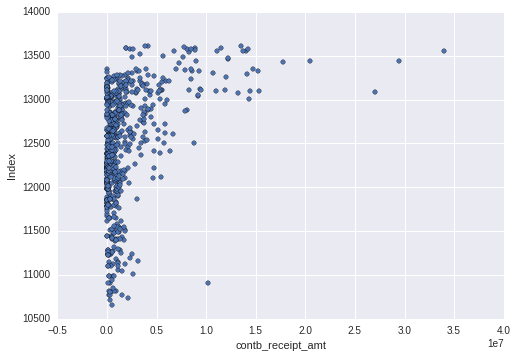

In [221]:
print('Correlation between index and total donations amount: ' + str(donations_per_day['contb_receipt_amt'].corr(donations_per_day['Index'])))
donations_per_day.plot(kind='scatter', x= 'contb_receipt_amt', y='Index')

As we can see there is a weak correlation between the DJIA index and the total amount of donations.

The supporters of different parties may react differently to the DJIA index so we are going to separate the donations by party.

In [222]:
donations.cand_nm.unique()

array(['Bachmann, Michele', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick', 'Cain, Herman',
       'Gingrich, Newt', 'McCotter, Thaddeus G', 'Huntsman, Jon',
       'Perry, Rick', 'Stein, Jill'], dtype=object)

Looking the names online we determine which party each candidate belongs to and add a party column to the donations data frame.

In [223]:
parties = {
    'Bachmann, Michele': 'Republican',
    'Romney, Mitt': 'Republican',
    'Obama, Barack': 'Democrat',
    "Roemer, Charles E. 'Buddy' III": 'Republican',
    'Pawlenty, Timothy': 'Republican',
    'Johnson, Gary Earl': 'Republican',
    'Paul, Ron': 'Republican', 
    'Santorum, Rick': 'Republican',
    'Cain, Herman': 'Republican',
    'Gingrich, Newt': 'Republican', 
    'McCotter, Thaddeus G': 'Republican',
    'Huntsman, Jon': 'Republican',
    'Perry, Rick': 'Republican',
    'Stein, Jill': 'Republican'
}

donations['party'] = donations.cand_nm.map(parties)

We will group our data by party and date and calculate the correlations again.

In [ ]:
donations

In [227]:
donations_per_day_per_party = pandas.merge(left = donations[donations.contb_receipt_amt > 0].groupby(['contb_receipt_dt', 'party'], as_index=False).sum(), right = djia, left_on = 'contb_receipt_dt', right_on = 'Date', how = 'left')
donations_per_day_per_party.drop('Date', axis=1, inplace=True)
donations_per_day_per_party

,contb_receipt_dt,party,contb_receipt_amt,file_num,Index,Percentage
0,2011-01-01,Republican,8600.00,2267370,NaN,NaN
1,2011-01-03,Republican,4800.00,1511580,11670.75,0.80535
2,2011-01-04,Republican,5000.00,1511580,11691.18,0.17505
3,2011-01-12,Republican,4150.00,4534740,11755.44,0.71591
4,2011-01-13,Republican,4000.00,5290530,11731.90,-0.20025
5,2011-01-14,Republican,6000.00,8313690,11787.38,0.47290
6,2011-01-15,Republican,500.00,1511580,11787.38,NaN
7,2011-01-16,Republican,750.00,1511580,11787.38,NaN
8,2011-01-17,Republican,500.00,755790,11787.38,NaN
9,2011-01-18,Republican,4800.00,1511580,11837.93,NaN


Correlation between index and donations amount for Republicans: 0.368962149778
Correlation between index and donations amount for Democrats: 0.324503257218


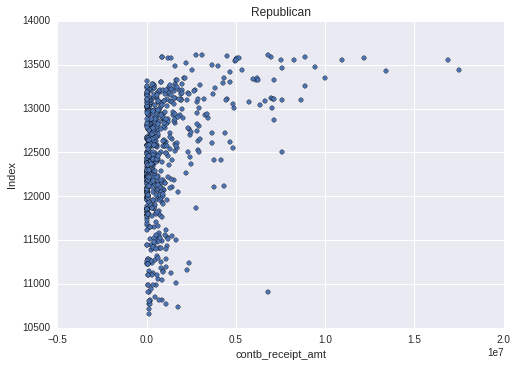

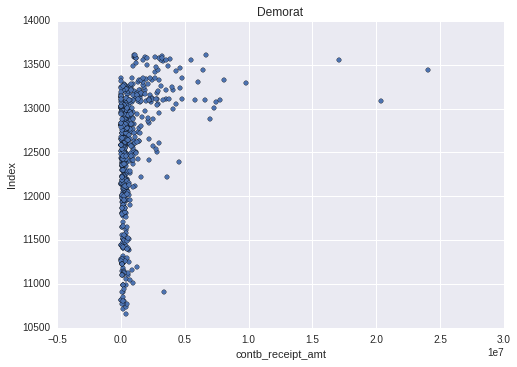

In [240]:
print('Correlation between index and total donations amount for Republicans: ' + str(donations_per_day_per_party.contb_receipt_amt[donations_per_day_per_party.party == 'Republican'].corr(donations_per_day_per_party.Index[donations_per_day_per_party.party == 'Republican'])))
print('Correlation between index and total donations amount for Democrats: ' + str(donations_per_day_per_party.contb_receipt_amt[donations_per_day_per_party.party == 'Democrat'].corr(donations_per_day_per_party.Index[donations_per_day_per_party.party == 'Democrat'])))
donations_per_day_per_party[donations_per_day_per_party.party == 'Republican'].plot(kind='scatter', x= 'contb_receipt_amt', y='Index', title = 'Republican')
donations_per_day_per_party[donations_per_day_per_party.party == 'Democrat'].plot(kind='scatter', x= 'contb_receipt_amt', y='Index', title = 'Demorat')

Still the correlation between the DJIA and the amount of donations is weak for both parties.

We can also explore other descriptive statisctics (apart from sum) concerning the amount of donations and the DJIA index like the number of donations (count), the median donation (median) etc. None of them shows a strong correlation.

Correlation between index and mean donation amount: -0.0357133901882
Correlation between index and number of donations: 0.423499410848
Correlation between index and median donation amount: -0.165421940908


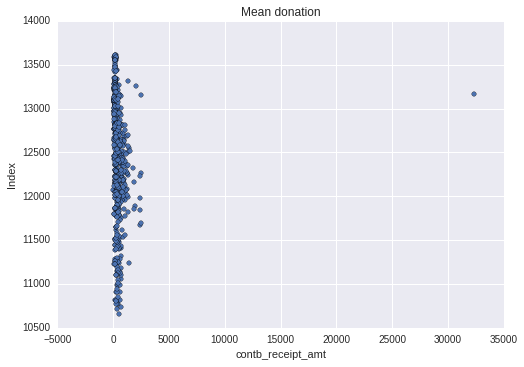

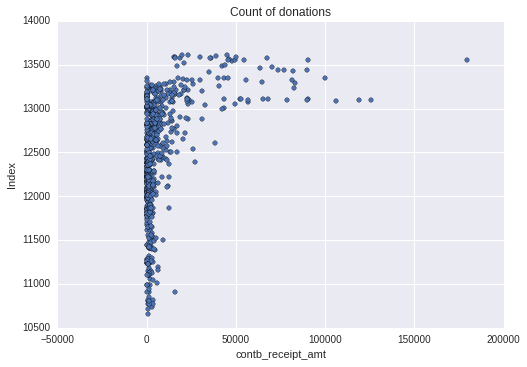

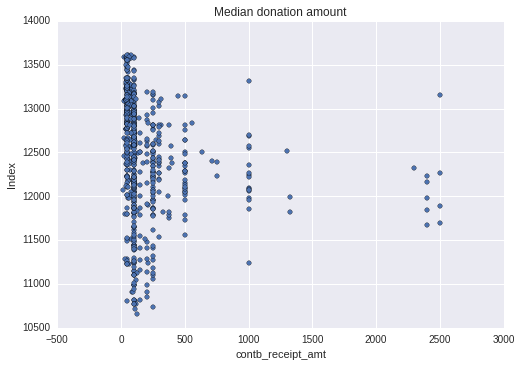

In [252]:
donations_per_day_mean = pandas.merge(left = donations[donations.contb_receipt_amt > 0].groupby('contb_receipt_dt', as_index=False).mean(), right = djia, left_on = 'contb_receipt_dt', right_on = 'Date', how = 'left')
donations_per_day_mean.drop('Date', axis=1, inplace=True)
print('Correlation between index and mean donation amount: ' + str(donations_per_day_mean['contb_receipt_amt'].corr(donations_per_day_mean['Index'])))
donations_per_day_mean.plot(kind='scatter', x= 'contb_receipt_amt', y='Index', title = 'Mean donation')

donations_per_day_count = pandas.merge(left = donations[donations.contb_receipt_amt > 0].groupby('contb_receipt_dt', as_index=False).count(), right = djia, left_on = 'contb_receipt_dt', right_on = 'Date', how = 'left')
donations_per_day_count.drop('Date', axis=1, inplace=True)
print('Correlation between index and number of donations: ' + str(donations_per_day_count['contb_receipt_amt'].corr(donations_per_day_count['Index'])))
donations_per_day_count.plot(kind='scatter', x= 'contb_receipt_amt', y='Index', title = 'Count of donations')

donations_per_day_median = pandas.merge(left = donations[donations.contb_receipt_amt > 0].groupby('contb_receipt_dt', as_index=False).median(), right = djia, left_on = 'contb_receipt_dt', right_on = 'Date', how = 'left')
donations_per_day_median.drop('Date', axis=1, inplace=True)
print('Correlation between index and median donation amount: ' + str(donations_per_day_median['contb_receipt_amt'].corr(donations_per_day_median['Index'])))
donations_per_day_median.plot(kind='scatter', x= 'contb_receipt_amt', y='Index', title = 'Median donation amount')

### Days left till election

The election day was November the 6th of 2012. It would be interesting to see the amount od donations as the election day approaches.

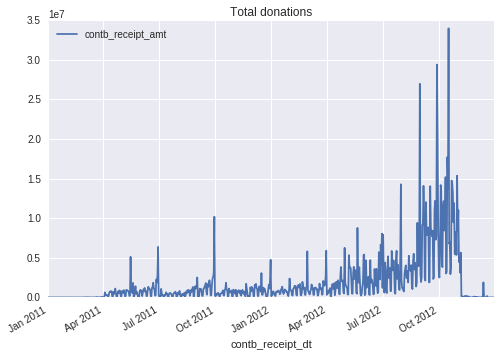

In [256]:
donations_per_day.plot(x = 'contb_receipt_dt', y = 'contb_receipt_amt', title = 'Total donations')

Correlation between days until election and total donation amount-0.559092533748


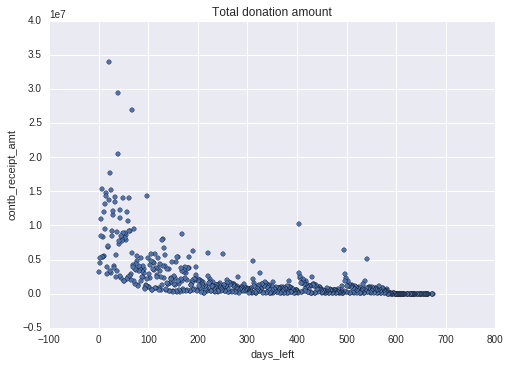

In [292]:
donations_per_day_days_left = donations_per_day
donations_per_day_days_left['days_left'] = (pandas.to_datetime('2012-11-06') - donations_per_day_days_left.contb_receipt_dt).dt.days
donations_per_day_days_left[(donations_per_day_days_left.days_left > 0)].plot(kind='scatter', x= 'days_left', y='contb_receipt_amt', title = 'Total donation amount')
print('Correlation between days until election and total donation amount' + str(donations_per_day_days_left['contb_receipt_amt'][donations_per_day_days_left.days_left > 0].corr(donations_per_day_days_left['days_left'])))

We have removed the entries after the election day as there is naturally a drop to the amount of donation after the elections. We can see that there is a medium strength correlation between the amount of days left until election and the total amount of donation to the campaigns.

## Census data

We have retrieved the census 2010 data from www.census.gov. There one main file we are interested in. The geography file which lists all census statictical locations and the total population for each statistical location. The geography file is fixed width and can be retrieved from [here](ftp://ftp.census.gov/census_2010/04-Summary_File_1/National/us2010.sf1.zip). The dictionary and other documentation for this data set is [here](http://www.census.gov/prod/cen2010/doc/sf1.pdf)

In [309]:
usgeo2010_widths = [6, 2, 3, 2, 3, 2, 7, 1, 1, 2, 3, 2, 2, 5, 2, 2, 5, 2, 2, 6, 1, 4, 2, 5, 2, 2, 4, 5, 2, 1, 3, 5, 2, 6, 1, 5, 2, 5, 2, 5, 3, 5, 2, 5, 3, 1, 1, 5, 2, 1, 1, 2, 3, 3, 6, 1, 3, 5, 5, 2, 5, 5, 5, 14, 14, 90, 1, 1, 9, 9, 11, 12, 2, 1, 6, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 1, 1, 5, 18]
usgeo2010_names = ['FILEID', 'STUSAB', 'SUMLEV', 'GEOCOMP', 'CHARITER', 'CIFSN', 'LOGRECNO',
         'REGION', 'DIVISION', 'STATE', 'COUNTY', 'COUNTYCC', 'COUNTYSC', 'COUSUB',
         'COUSUBCC', 'COUSUBSC', 'PLACE', 'PLACECC', 'PLACESC', 'TRACT', 'BLKGRP',
         'BLOCK', 'IUC', 'CONCIT', 'CONCITCC', 'CONCITSC', 'AIANHH', 'AIANHHFP',
         'AIANHHCC', 'AIHHTLI', 'AITSCE', 'AITS', 'AITSCC', 'TTRACT', 'TBLKGRP',
         'ANRC', 'ANRCCC', 'CBSA', 'CBSASC', 'METDIV', 'CSA', 'NECTA',
         'NECTASC', 'NECTADIV', 'CNECTA', 'CBSAPCI', 'NECTAPCI', 'UA', 'UASC',
         'UATYPE', 'UR', 'CD', 'SLDU', 'SLDL', 'VTD', 'VTDI',
         'RESERVE2', 'ZCTA5', 'SUBMCD', 'SUBMCDCC', 'SDELM', 'SDSEC', 'SDUNI',
         'AREALAND', 'AREAWATR', 'NAME', 'FUNCSTAT', 'GCUNI', 'POP100', 'HU100',
         'INTPTLAT', 'INTPTLON', 'LSADC', 'PARTFLAG', 'RESERVE3', 'UGA', 'STATENS',
         'COUNTYNS', 'COUSUBNS', 'PLACENS', 'CONCITNS', 'AIANHHNS', 'AITSNS', 'ANRCNS',
         'SUBMCDNS', 'CD113', 'CD114', 'CD115', 'SLDU2', 'SLDU3', 'SLDU4',
         'SLDL2', 'SLDL3', 'SLDL4', 'AIANHHSC', 'CSASC', 'CNECTASC', 'MEMI',
         'NMEMI', 'PUMA', 'RESERVED']
usgeo2010_states = {1:'AL',
                    2:'AK',
                    4:'AZ',
                    5:'AR',
                    6:'CA',
                    8:'CO',
                    9:'CT',
                    10:'DE',
                    11:'DC',
                    12:'FL',
                    13:'GA',
                    15:'HI',
                    16:'ID',
                    17:'IL',
                    18:'IN',
                    19:'IA',
                    20:'KS',
                    21:'KY',
                    22:'LA',
                    23:'ME',
                    24:'MD',
                    25:'MA',
                    26:'MI',
                    27:'MN',
                    28:'MS',
                    29:'MO',
                    30:'MT',
                    31:'NE',
                    32:'NV',
                    33:'NH',
                    34:'NJ',
                    35:'NM',
                    36:'NY',
                    37:'NC',
                    38:'ND',
                    39:'OH',
                    40:'OK',
                    41:'OR',
                    42:'PA',
                    44:'RI',
                    45:'SC',
                    46:'SD',
                    47:'TN',
                    48:'TX',
                    49:'UT',
                    50:'VT',
                    51:'VA',
                    53:'WA',
                    54:'WV',
                    55:'WI',
                    56:'WY',
                    72:'Puerto_Rico'}

usgeo2010 = pandas.read_fwf('sf1/usgeo2010.sf1', widths = usgeo2010_widths, header = None, names = usgeo2010_names)
usgeo2010['STATE'] = usgeo2010.STATE.map(usgeo2010_states)

We will try to clean the donations data set. We observer that there are someentries which contain state acronums that do not exist. This is due to donation from aboard or mistaken entries.

In [349]:
donations.contbr_st[~donations.contbr_st.isin(usgeo2010_states.values())].unique()
print('There are ' + str(len(donations.contbr_st[~donations.contbr_st.isin(usgeo2010_states.values())])) + ' entries with invalid states')

There are 13410 entries with invalid states


We will remove these.

In [352]:
donations = donations[donations.contbr_st.isin(usgeo2010_states.values())]

Also there are 84 entries where there is no city reported. We will remove those two as we don't want to match a whole state.

In [359]:
print('There are ' + str(len(donations[donations.contbr_city.isnull()])) + ' entries with no city recorded')
donations = donations[~donations.contbr_city.isnull()]

There are 84 entries with no city recorded


In [508]:
donations_by_state_city = donations.groupby(['contbr_st', 'contbr_city', 'party'], as_index = False).sum()
donations_by_state_city.drop('file_num', axis=1, inplace=True)
donations_by_state_city

,contbr_st,contbr_city,party,contb_receipt_amt
0,AK,AKIAK,Democrat,764.00
1,AK,AKUTAN,Republican,200.00
2,AK,ALAKANUK,Republican,250.00
3,AK,AMBLER,Democrat,2185.00
4,AK,ANC,Democrat,225.00
5,AK,ANCHOR POINT,Democrat,85.00
6,AK,ANCHOR POINT,Republican,5002.00
7,AK,ANCHORAGE,Democrat,719281.39
8,AK,ANCHORAGE,Republican,789477.64
9,AK,"ANCHORAGE,",Democrat,75.00


As we can see the city names can have several typos, same cities are written with different spellings and the names will differ from the ones used by the census organization. To overcome these problems we will use fuzzy matching with the difflib library. We will try to match the reported city name with a 'place' (sumlevel 70) within the same state in the census data. If several places with similar names exist (eg Ankhorage, Ankhorage subarbs etc) we will pick the one with the largest population. This may take some time and memory.

In [513]:
def fuzzy_match(x):
    a = difflib.get_close_matches(x[1], usgeo2010.NAME[(usgeo2010.STATE == x[0]) & ((usgeo2010.SUMLEV == 70) | (usgeo2010.SUMLEV == 70))].str.upper().unique(), n=1, cutoff = 0.5)
    if len(a)>0:
        return a[0]
    else:
        return None

donations_by_state_city['fuzzy_name'] = donations_by_state_city.apply(fuzzy_match, axis=1)
donations_by_state_city

,contbr_st,contbr_city,party,contb_receipt_amt,fuzzy_name
0,AK,AKIAK,Democrat,764.00,AKIAK CITY
1,AK,AKUTAN,Republican,200.00,AKUTAN CITY
2,AK,ALAKANUK,Republican,250.00,ALAKANUK CITY
3,AK,AMBLER,Democrat,2185.00,AMBLER CITY
4,AK,ANC,Democrat,225.00,SLANA CDP
5,AK,ANCHOR POINT,Democrat,85.00,ANCHOR POINT CDP
6,AK,ANCHOR POINT,Republican,5002.00,ANCHOR POINT CDP
7,AK,ANCHORAGE,Democrat,719281.39,ANCHORAGE MUNICIPALITY
8,AK,ANCHORAGE,Republican,789477.64,ANCHORAGE MUNICIPALITY
9,AK,"ANCHORAGE,",Democrat,75.00,ANCHORAGE MUNICIPALITY


Any cities not matched in the census data will be considered minor cities and we will add this `SMALL CITY` indicator in place on `NaN`s.

In [522]:
donations_by_state_city.fillna(value='SMALL CITY', inplace=True)

Again we will groupby state and city name and sum to sum the corrected city names

In [524]:
donations_by_state_city = donations_by_state_city.groupby(['contbr_st', 'fuzzy_name', 'party'], as_index = False).sum()
donations_by_state_city

,contbr_st,fuzzy_name,party,contb_receipt_amt
0,AK,AKIAK CITY,Democrat,764.00
1,AK,AKUTAN CITY,Republican,200.00
2,AK,ALAKANUK CITY,Republican,250.00
3,AK,ALATNA CDP,Democrat,2700.00
4,AK,ALATNA CDP,Republican,250.00
5,AK,AMBLER CITY,Democrat,2185.00
6,AK,ANCHOR POINT CDP,Democrat,85.00
7,AK,ANCHOR POINT CDP,Republican,5002.00
8,AK,ANCHORAGE MUNICIPALITY,Democrat,719489.39
9,AK,ANCHORAGE MUNICIPALITY,Republican,794477.64


Now we will merge the donations data with the census data

In [549]:
usgeo2010['NAME_UPPER'] = usgeo2010['NAME'].str.upper()
donations_by_state_city=pandas.merge(left=donations_by_state_city, right=usgeo2010[['POP100', 'NAME_UPPER', 'STATE']][(usgeo2010.SUMLEV == 70)].sort_values('POP100', ascending=False).drop_duplicates(subset = ['NAME_UPPER', 'STATE'], keep = 'first'), left_on = ['contbr_st','fuzzy_name'], right_on = ['STATE','NAME_UPPER'], how = 'left')

In [593]:
donations_by_state_city.fillna(value = 1, inplace=True)

We will separate the cities in bins based on their size. We will use the same bins as the census organization:

In [594]:
def bins(x):
    if x[0] < 25000:
        return '0-25000'
    elif x[0] < 50000:
        return '25000-50000'
    elif x[0] < 100000:
        return '50000-100000'
    elif x[0] < 250000:
        return '100000-250000'
    elif x[0] < 500000:
        return '250000-500000'
    elif x[0] < 1000000:
        return '500000-1000000'
    elif x[0] < 2500000:
        return '1000000-2500000'
    else:
        return '2500000+'

donations_by_state_city['city_size'] = donations_by_state_city[['POP100']].apply(bins, axis=1)
donations_by_state_city

,contbr_st,fuzzy_name,party,contb_receipt_amt,POP100,NAME_UPPER,STATE,city_size
0,AK,AKIAK CITY,Democrat,764.00,346,AKIAK CITY,AK,0-25000
1,AK,AKUTAN CITY,Republican,200.00,1027,AKUTAN CITY,AK,0-25000
2,AK,ALAKANUK CITY,Republican,250.00,677,ALAKANUK CITY,AK,0-25000
3,AK,ALATNA CDP,Democrat,2700.00,37,ALATNA CDP,AK,0-25000
4,AK,ALATNA CDP,Republican,250.00,37,ALATNA CDP,AK,0-25000
5,AK,AMBLER CITY,Democrat,2185.00,258,AMBLER CITY,AK,0-25000
6,AK,ANCHOR POINT CDP,Democrat,85.00,1930,ANCHOR POINT CDP,AK,0-25000
7,AK,ANCHOR POINT CDP,Republican,5002.00,1930,ANCHOR POINT CDP,AK,0-25000
8,AK,ANCHORAGE MUNICIPALITY,Democrat,719489.39,291826,ANCHORAGE MUNICIPALITY,AK,250000-500000
9,AK,ANCHORAGE MUNICIPALITY,Republican,794477.64,291826,ANCHORAGE MUNICIPALITY,AK,250000-500000


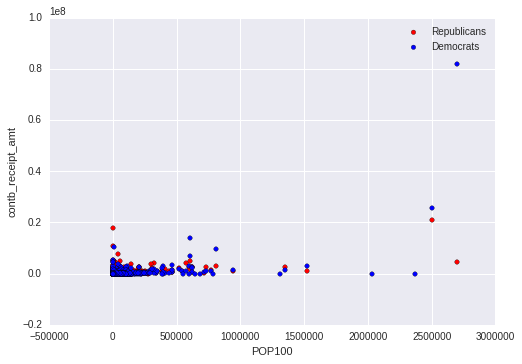

In [595]:
bins = [25000, 50000, 100000, 250000, 500000, 1000000, 2500000, 5000000, 10000000]
ax = donations_by_state_city[(donations_by_state_city.contb_receipt_amt > 0) & (donations_by_state_city.party == 'Republican')].plot(kind='scatter', x='POP100', y='contb_receipt_amt', color='Red', label = 'Republicans')
donations_by_state_city[(donations_by_state_city.contb_receipt_amt > 0) & (donations_by_state_city.party == 'Democrat')].plot(kind='scatter', x='POP100', y='contb_receipt_amt', color='Blue', label = 'Democrats', ax=ax)
#donations_by_state_city[donations_by_state_city.contb_receipt_amt < 0]

,city_size,party,contb_receipt_amt
0,0-25000,Democrat,2.223297e+08
1,0-25000,Republican,4.379112e+08
2,100000-250000,Democrat,3.750929e+07
3,100000-250000,Republican,5.063983e+07
4,1000000-2500000,Democrat,4.296478e+06
5,1000000-2500000,Republican,3.605364e+06
6,25000-50000,Democrat,4.848855e+07
7,25000-50000,Republican,7.872144e+07
8,250000-500000,Democrat,2.237043e+07
9,250000-500000,Republican,2.545714e+07


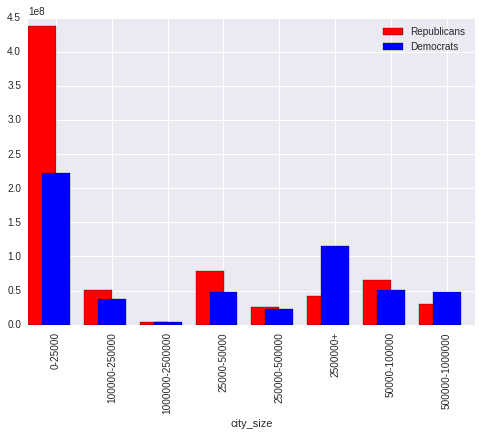

In [592]:
ax = donations_by_state_city[donations_by_state_city.party == 'Republican'].groupby(['city_size', 'party'], as_index=False).sum().drop('POP100', axis=1).plot(kind = 'bar', x='city_size', y='contb_receipt_amt', color = 'Red', label = 'Republicans', position=1)
donations_by_state_city[donations_by_state_city.party == 'Democrat'].groupby(['city_size', 'party'], as_index=False).sum().drop('POP100', axis=1).plot(kind = 'bar', x='city_size', y='contb_receipt_amt', color = 'Blue', label = 'Democrats', ax=ax)
donations_by_state_city.groupby(['city_size', 'party'], as_index=False).sum().drop('POP100', axis=1)

As we can see in the barplot above the Democrats gathered much more donations in large and medium sized cities while the Republicans gathered many more donations in small towns.